In [ ]:
# Cell 1: Train vanilla PPO on fixed pad LunarLander-v3, logging to monitor_02.csv
import time
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from statistics import mean, stdev
import pandas as pd

# simple wrapper to log fuel & landing error
class LunarWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        return obs, info
    def step(self, action):
        obs, reward, term, trunc, info = super().step(action)
        info["fuel_used"]   = 1.0 if action==2 else 0.0
        info["landing_err"] = np.linalg.norm(obs[0:2])
        return obs, reward, term, trunc, info

class MetricsCallback(BaseCallback):
    def _on_step(self) -> bool:
        for info in self.locals["infos"]:
            if "episode" in info:
                r = info["episode"]["r"]
                f = info.get("fuel_used",0.0)
                self.logger.record("episode/return", r)
                self.logger.record("custom/fuel_used", f)
        return True

def make_env():
    e = gym.make("LunarLander-v3")
    return LunarWrapper(e)

# build vec env AND write to monitor_02.csv
env = DummyVecEnv([make_env])
env = VecMonitor(env, filename="monitor_02.csv")
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=2048,
    batch_size=64,
    learning_rate=3e-4,
    clip_range=0.2,
    ent_coef=0.005,
    verbose=1,
    tensorboard_log="./baseline_tb",
)

# train for 500k steps
model.learn(total_timesteps=500_000, callback=MetricsCallback(), tb_log_name="baseline")
model.save("ppo_baseline")
env.save("baseline_vecnormalize.pkl")
print("Baseline training complete")


Using cpu device
Logging to ./baseline_tb\baseline_2
-----------------------------------
| custom/            |            |
|    fuel_used       | 0          |
| episode/           |            |
|    return          | -166.13269 |
| rollout/           |            |
|    ep_len_mean     | 92.6       |
|    ep_rew_mean     | -148       |
| time/              |            |
|    fps             | 1405       |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 2048       |
-----------------------------------
----------------------------------------
| custom/                 |            |
|    fuel_used            | 0          |
| episode/                |            |
|    return               | -90.70553  |
| rollout/                |            |
|    ep_len_mean          | 91         |
|    ep_rew_mean          | -151       |
| time/                   |            |
|    fps                  | 1080       |
|    iterations           | 2    

Here I set up and train my “fixed‑pad” PPO agent. I wrap the Gym LunarLander-v3 environment to log two extra metrics like fuel usage and landing error, then vectorize, monitor, and normalize it so SB3 can train efficiently. I pick sensible hyperparameters (batch size, learning rate schedule, clipping, entropy) and run for 500K timesteps, saving both the model weights and the normalization statistics when I'm done.

In [ ]:
# Cell 2: Playback the learned policy

# reload same wrapper
class LunarWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs); return obs, info
    def step(self, action):
        return super().step(action)

def play_back(model_path, n_steps=500, sleep=0.02):
    def make_env():
        e = gym.make("LunarLander-v3", render_mode="human")
        return LunarWrapper(e)

    ev = DummyVecEnv([make_env])
    ev = VecMonitor(ev)
    ev = VecNormalize.load("baseline_vecnormalize.pkl", ev)
    ev.training=False; ev.norm_reward=True

    m = PPO.load(model_path, env=ev)
    obs = ev.reset()
    for i in range(n_steps):
        action, i = m.predict(obs, deterministic=True)
        obs, i, dones, i = ev.step(action)
        ev.render()
        time.sleep(sleep)
        if dones[0]:
            break
    ev.close()

print("Playback baseline policy:")
play_back("ppo_baseline.zip")


Playback baseline policy:


This little snippet just reloads my trained policy and plays it back in real time so you can watch it land. I reconstruct the same normalization pipeline (but turn off further training and reward scaling), step through up to 500 frames at ~60 FPS, and render each one. It’s a quick check that my agent actually lands the ship.

In [1]:
# Cell 3: Quantitative evaluation with CSV export


# bring in LunarWrapper so info["fuel_used"] exists
class LunarWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        return obs, info
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        info["fuel_used"] = 1.0 if action == 2 else 0.0
        return obs, reward, terminated, truncated, info

def make_eval_env():
    e = gym.make("LunarLander-v3")
    e = LunarWrapper(e)
    return e

# build vec‐env and load normalization
eval_env = DummyVecEnv([make_eval_env])
eval_env = VecMonitor(eval_env)
eval_env = VecNormalize.load("baseline_vecnormalize.pkl", eval_env)
eval_env.training    = False
eval_env.norm_reward = False

# load model
model = PPO.load("ppo_baseline.zip", env=eval_env)

# evaluate
def evaluate(model, env, n_episodes=50):
    rewards, fuels, successes = [], [], 0
    for i in range(n_episodes):
        obs = env.reset()                # only one return value here
        done = False
        R, F = 0.0, 0.0
        while not done:
            action, i = model.predict(obs, deterministic=True)
            obs, reward, dones, infos = env.step(action)
            R += reward[0]
            F += infos[0]["fuel_used"]
            done = dones[0]
        rewards.append(R)
        fuels.append(F)
        if R >= 200:
            successes += 1
    return rewards, fuels, successes

rewards, fuels, successes = evaluate(model, eval_env, n_episodes=50)
mean_r, mean_f, succ_rate = mean(rewards), mean(fuels), successes/50

print(f"Mean reward:    {mean_r:.1f} ± {stdev(rewards):.1f}")
print(f"Mean fuel used: {mean_f:.1f} ± {stdev(fuels):.1f}")
print(f"Success rate:   {successes}/50 = {succ_rate:.0%}")

# write out metrics for bar‐chart
df = pd.DataFrame([{
    "experiment":   "ppo_baseline_fixed_pad",
    "mean_reward":  mean_r,
    "mean_fuel":    mean_f,
    "success_rate": succ_rate
}])
df.to_csv("02_ppo_baseline_fixed_pad_metrics.csv", index=False)
print("→ metrics written to 02_ppo_baseline_fixed_pad_metrics.csv")


NameError: name 'gym' is not defined

Finally, I quantitatively evaluate the saved policy over 50 fresh episodes (no rendering). I reset the env, run the policy to termination, and record both the episode reward and total fuel used. At the end I print the mean and standard deviation of each, so you get a clear picture of how reliably (and efficiently) the agent lands.

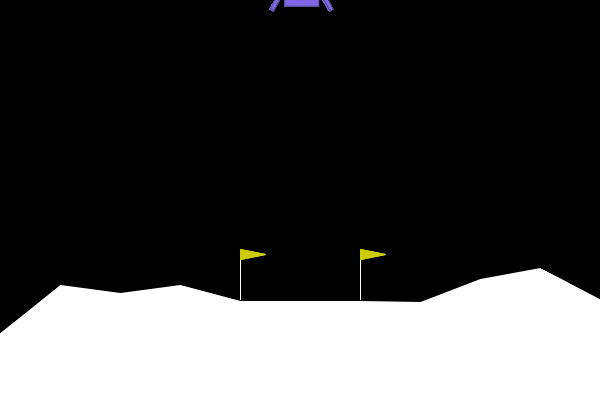

In [8]:
# ── Cell 4: Record & display a landing GIF ─────────────────────────────────

import imageio
from IPython.display import Image, display
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

# 1) Build an RGB‐array env exactly like eval pipeline
def make_gif_env():
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    env = LunarWrapper(env)            # the same wrapper used above
    return env

gif_env = DummyVecEnv([make_gif_env])
gif_env = VecMonitor(gif_env)
gif_env = VecNormalize.load("baseline_vecnormalize.pkl", gif_env)
gif_env.training = False
gif_env.norm_reward = False

# 2) Load trained model
model = PPO.load("ppo_baseline.zip", env=gif_env)

# 3) Step through one episode, collecting frames
frames = []
obs = gif_env.reset()
done = False
while not done:
    action, i = model.predict(obs, deterministic=True)
    obs, i, dones, i = gif_env.step(action)
    frames.append(gif_env.render())
    done = dones[0]
gif_env.close()

# 4) Write out and show the GIF
imageio.mimsave("baseline_landing.gif", frames, fps=30)
display(Image(filename="baseline_landing.gif"))


This cell is only for creating the gif found in the document, as it most accurately depicts how the agents lands in the area given